<a href="https://colab.research.google.com/github/aswarth123/Federated_Learning_MNIST/blob/main/FederatedLearning(SVM)_MNIST_version1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import random
import copy
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import tensorflow as tf
import matplotlib.pyplot as plt

# SVM

In [ ]:
class SVM:

  def __init__(self, X_train, y_train, X_test, y_test, val=True, val_type='k_fold', val_distribution='balanced', k=5, learning_rate=0.001, lambda_param=0.01, n_iters=1000):

    self.lr = learning_rate
    self.lambda_param = lambda_param
    self.n_iters = n_iters

    self.X_train = X_train
    self.y_train = y_train

    self.X_test = X_test
    self.y_test = y_test

    self.val_distribution = val_distribution
    self.val = val
    self.val_type=val_type
    self.val_distribution=val_distribution
    self.k=k

    self.w = np.array([])
    self.b = None


  def Gradient_update(self, X_train, y_train, X_val=None, y_val=None):

    n_samples, n_features = X_train.shape  
    y_ = np.where(y_train <= 0, -1, 1)
          
    if self.w.size == 0 and self.b is None :
      self.w = np.zeros(n_features)
      self.b = 0

    w_best = np.zeros(n_features)
    b_best = 0

    acc_list = [] 
    for i in range(0,self.n_iters):
      for idx, x_i in enumerate(X_train):
        condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
        if condition:
          self.w -= self.lr * (2 * self.lambda_param * self.w)
        else:
          self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx]))
          self.b -= self.lr * y_[idx]

      if i%10 == 0 and self.val:
        approx_w = np.dot(X_val, self.w) - self.b
        approx_w = np.sign(approx_w)
        res_w = np.where(approx_w<0, 0, approx_w)

        approx_w_best = np.dot(X_val, w_best) - b_best
        approx_w_best = np.sign(approx_w_best)
        res_w_best = np.where(approx_w_best<0, 0, approx_w_best)
          
        if (accuracy_score(y_val, res_w_best) < accuracy_score(y_val, res_w)):
          w_best = copy.deepcopy(self.w)
          b_best = copy.deepcopy(self.b)
        else:  
          self.w = copy.deepcopy(w_best)
          self.b = copy.deepcopy(b_best)  
          break

  def Cross_validation(self, val_split):

    if (self.val_distribution == 'balanced'):
      X_train0, X_val0, y_train0, y_val0 = train_test_split(self.X_train[0], self.y_train[0], test_size=val_split)
      X_train1, X_val1, y_train1, y_val1 = train_test_split(self.X_train[1], self.y_train[1], test_size=val_split)

      X_train = np.concatenate((X_train0,X_train1),axis=0)
      y_train = np.concatenate((y_train0,y_train1),axis=0)

      X_val = np.concatenate((X_val0,X_val1),axis=0)
      y_val = np.concatenate((y_val0,y_val1),axis=0)

    elif (self.val_distribution == 'unbalanced'):
      X_train = np.concatenate((self.X_train[0],self.X_train[1]),axis=0)
      y_train = np.concatenate((self.y_train[0],self.y_train[1]),axis=0)

      X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_split)

    X_train, y_train = self.random_shuffle(X_train, y_train)
    self.Gradient_update(X_train, y_train, X_val, y_val)

  def k_fold_cross_validation(self):

    if (self.val_distribution == 'unbalanced'):
      X_train = np.concatenate((self.X_train[0],self.X_train[1]),axis=0)
      y_train = np.concatenate((self.y_train[0],self.y_train[1]),axis=0)

      X_train_, X_train0, y_train_, y_train0 = train_test_split(X_train, y_train, test_size=round(1/self.k,2), shuffle=True)

      X_train = []
      y_train = []

      X_train.append(copy.deepcopy(X_train0))
      y_train.append(copy.deepcopy(y_train0))
      k = self.k - 1

      X_train0 = np.array_split(X_train_,k)
      y_train0 = np.array_split(y_train_,k)

      for i in range(k):
        X_train.append(X_train0[i])
        y_train.append(y_train0[i])

    elif (self.val_distribution == 'balanced'):
      X_train0 = np.array_split(self.X_train[0],self.k)
      X_train1 = np.array_split(self.X_train[1],self.k)
      y_train0 = np.array_split(self.y_train[0],self.k)
      y_train1 = np.array_split(self.y_train[1],self.k)
      X_train = []
      y_train = []
      for i in range(self.k):
        X_train.append(np.concatenate((X_train0[i],X_train1[i]),axis=0))
        y_train.append(np.concatenate((y_train0[i],y_train1[i]),axis=0))

    if self.w.size == 0 and self.b == None:
      w = np.zeros(self.X_train[0].shape[1])
      b = 0
    else:
      w = copy.deepcopy(self.w)
      b = self.b

    w_list = []
    b_list = []
    acc_list = []
    for i in range(self.k):
      X_train_temp = np.zeros((1,X_train[0].shape[1]))
      y_train_temp = np.array([])

      for j in range(self.k):
        if (j!=i):
          X_train_temp = np.concatenate((X_train_temp,X_train[j]),axis=0)
          y_train_temp = np.concatenate((y_train_temp,y_train[j]),axis=0)
        else:
          X_val = X_train[j]
          y_val = y_train[j]


      X_train_temp = np.delete(X_train_temp,0,0)
      X_train_temp, y_train_temp = self.random_shuffle(X_train_temp, y_train_temp)
      self.Gradient_update(X_train_temp, y_train_temp, X_val, y_val)
      print(self.accuracy())
      w_list.append(self.w)
      b_list.append(self.b)

      test_w = np.dot(X_val, self.w) - self.b
      test_w = np.sign(test_w)
      res_val = np.where(test_w<0,0,test_w)

      acc_list.append(accuracy_score(y_val, res_val))
    
      self.w = copy.deepcopy(w)
      self.b = b

    self.w = copy.deepcopy(w_list[acc_list.index(max(acc_list))])
    self.b = b_list[acc_list.index(max(acc_list))]
  

  def fit(self):
    if self.val_type == 'k_fold' and self.val:
      self.k_fold_cross_validation()
    
    elif self.val_type == 'cross_val' and self.val:
      self.Cross_validation(0.2)
    
    elif not self.val:
      X_train = np.concatenate((self.X_train[0],self.X_train[1]),axis=0)
      y_train = np.concatenate((self.y_train[0],self.y_train[1]),axis=0)
      X_train, y_train = self.random_shuffle(X_train, y_train)
      self.Gradient_update(X_train, y_train)

  def random_shuffle(self, X_train, y_train):
    self.x_tr, self.x_te, self.y_tr, self.y_te = train_test_split(X_train,y_train,test_size=0.5)
    return np.concatenate((self.x_tr, self.x_te),axis=0), np.concatenate((self.y_tr, self.y_te),axis=0)

  def predict(self):
     approx = np.dot(self.X_test, self.w) - self.b
     approx = np.sign(approx)
     return np.where(approx<0, 0, approx)

  def accuracy(self):
    return accuracy_score(self.y_test, self.predict())*100


# FL SVM

In [ ]:
class Federated_SVM:

  def __init__(self, n_clients=4, val=True, val_type='k_fold', val_distribution='balanced', k=5, learning_rate=0.001, lambda_param=0.01, n_iters=100):
    self.n_clients = n_clients
    self.learning_rate = learning_rate
    self.lambda_param = lambda_param
    self.n_iters = n_iters
    self.val = val
    self.val_type = val_type
    self.val_distribution = val_distribution
    self.client_distribution = []
    self.k = k
    self.X_test = None
    self.y_test = None
    self.noise = None
    
  def create_clients(self, X_train, y_train, X_test, y_test):
    self.clients=[]
    for i in range(self.n_clients):
      self.client_distribution.append(X_train[i][0].shape[0] + X_train[i][1].shape[0])
      self.clients.append(SVM(X_train[i],y_train[i], X_test, y_test, self.val, self.val_type, self.val_distribution, self.k, self.learning_rate, self.lambda_param, self.n_iters))
    self.X_test = copy.deepcopy(X_test)
    self.y_test = copy.deepcopy(y_test)
  

  def average_aggregator(self, parameter_list):
    w = np.zeros(parameter_list[0].shape[0])
    b = 0
    for i in range(0,2*self.n_clients,2):
        w = np.add(w,parameter_list[i]*self.client_distribution[i//2]/sum(self.client_distribution))
        b = b + parameter_list[i+1]
    return (w, b/self.n_clients)

  def fit(self, g_iters, aggregator):
    w_best = np.zeros(self.X_test.shape[1])
    b_best = 0
    for i in range(0,g_iters):
      print('global round',i+1)
      for j in range(0,self.n_clients):
        if i==0:
          self.clients[j].fit()
        else:
          self.clients[j].w = copy.deepcopy(w_agg) 
          self.clients[j].b = copy.deepcopy(b_agg)
          self.clients[j].fit()
        print('client',j+1,self.clients[j].accuracy())          
      parameter_list = []
      for k in range(0,self.n_clients):
        parameter_list.append(self.clients[k].w)
        parameter_list.append(self.clients[k].b)

      w_agg, b_agg = aggregator(parameter_list)  
        
      if self.accuracy(w_agg,b_agg)>self.accuracy(w_best,b_best) or i==0:
        w_best=copy.deepcopy(w_agg)
        b_best=copy.deepcopy(b_agg)
      print('global test acc',self.accuracy(w_best,b_best))

  def predict(self,w,b):
     approx = np.dot(self.X_test, w) - b
     approx = np.sign(approx)
     return np.where(approx<0, 0, 1)
  
  def accuracy(self,w,b):
    return accuracy_score(self.y_test, self.predict(w,b))*100


# Utility Functions

In [ ]:
def get_clients(class1, class2, n_clients = 3):

  clients_X = []
  clients_y = []

  clientsXtest = []
  clientsYtest = []

  clusters_1 = KMeans(n_clusters=n_clients, random_state=0).fit_predict(class1)
  clusters_2 = KMeans(n_clusters=n_clients, random_state=0).fit_predict(class2)

  for i in range(n_clients):

    X_train0, X_test0, y_train0, y_test0 = train_test_split(class1[clusters_1 == i],np.zeros((class1[clusters_1 == i].shape[0],)),test_size=0.2)
    X_train1, X_test1, y_train1, y_test1 = train_test_split(class2[clusters_2 == i],np.ones((class2[clusters_2 == i].shape[0],)),test_size=0.2)

    clients_X.append([X_train0, X_train1])
    clients_y.append([y_train0, y_train1])

    clientsXtest.extend([X_test0,X_test1])
    clientsYtest.extend([y_test0,y_test1])

  X_test = np.concatenate(clientsXtest,axis=0)
  y_test = np.concatenate(clientsYtest,axis=0)

  return clients_X,clients_y,X_test,y_test

In [ ]:
def get_total_from_clients(clients_X,clients_y):
  x_train0 = [i[0] for i in clients_X]
  x_train0 = np.concatenate(x_train0, axis=0)
  x_train1 = [i[1] for i in clients_X]
  x_train1 = np.concatenate(x_train1, axis=0)
  y_train0 = [i[0] for i in clients_y]
  y_train0 = np.concatenate(y_train0, axis=0)
  y_train1 = [i[1] for i in clients_y]
  y_train1 = np.concatenate(y_train1, axis=0)

  return ([x_train0,x_train1],[y_train0,y_train1])    

In [ ]:
def create_kmeans_clusters(X, Y, n_clusters = 3, random_state = 0):
  clusters = KMeans(n_clusters=n_clusters, random_state=random_state).fit_predict(X)
  result = []
  for i in range(n_clusters):
    result.append(X[clusters == i])
    result.append(Y[clusters == i])
  return tuple(result)  

In [ ]:
def load_mnist_return_required_digits(n1, n2):
  # Loading the mnist dataset and concatenating train - test sets
  (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
  x_total = np.concatenate((x_train, x_test), axis=0)
  y_total = np.concatenate((y_train, y_test), axis=0)

  # Normalizing and reshaping the data
  x_total = x_total/255 
  x_total = x_total.reshape(x_total.shape[0],784)

  x_n1 = x_total[y_total == n1]
  y_n1 = y_total[y_total == n1]

  x_n2 = x_total[y_total == n2]
  y_n2 = y_total[y_total == n2]

  return [(x_n1, y_n1),(x_n2, y_n2)]

# Digits 0 and 6

### Loading the data of 0 and 6

In [ ]:
data = load_mnist_return_required_digits(0, 6)

11501568/11490434 [==============================] - 0s 0us/step


### Dividing the data of digits 0 and 6 into clusters using the KMeans algorithm
The images of 0 and 6 are divided into 3 three clusters each.

Text(0.5, 1.0, 'Cluster 3')

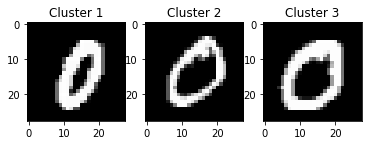

In [ ]:
x_0_c1, y_0_c1, x_0_c2, y_0_c2, x_0_c3, y_0_c3 = create_kmeans_clusters(data[0][0], data[0][1])
fig, axs = plt.subplots(1, 3)
axs[0].imshow(x_0_c1[0].reshape(28,28),cmap='gray')
axs[0].set_title('Cluster 1')
axs[1].imshow(x_0_c2[0].reshape(28,28),cmap='gray')
axs[1].set_title('Cluster 2')
axs[2].imshow(x_0_c3[0].reshape(28,28),cmap='gray')
axs[2].set_title('Cluster 3')

Text(0.5, 1.0, 'Cluster 3')

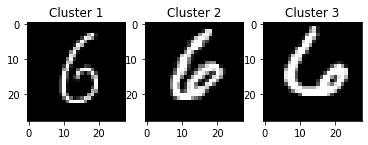

In [ ]:
x_6_c1, y_6_c1, x_6_c2, y_6_c2, x_6_c3, y_6_c3 = create_kmeans_clusters(data[1][0], data[1][1])
fig, axs = plt.subplots(1, 3)
axs[0].imshow(x_6_c1[0].reshape(28,28),cmap='gray')
axs[0].set_title('Cluster 1')
axs[1].imshow(x_6_c2[0].reshape(28,28),cmap='gray')
axs[1].set_title('Cluster 2')
axs[2].imshow(x_6_c3[0].reshape(28,28),cmap='gray')
axs[2].set_title('Cluster 3')

### Creation of individual train sets for the clients, global train set for the SVM model and a global test set containing the data from all the clusters



In [ ]:
clients_X,clients_y,X_test,y_test = get_clients(data[0][0], data[1][0], n_clients = 3)

In [ ]:
xtrain_gl, ytrain_gl = get_total_from_clients(clients_X,clients_y)

### Federated learning model and SVM model training

#### Training the models without validation

In [ ]:
f_svm = Federated_SVM(n_clients = 3, val=False, n_iters=150)
f_svm.create_clients(clients_X,clients_y,X_test,y_test)

In [ ]:
clf = SVM(xtrain_gl, ytrain_gl, X_test, y_test, val=False, n_iters=1000)
clf.fit()
print(clf.accuracy())

99.23857868020305


In [ ]:
f_svm.fit(10,f_svm.average_aggregator)

global round 1
client 1 91.95068890500363
client 2 92.5670775924583
client 3 93.32849891225526
global test acc 97.7519941986947
global round 2
client 1 92.27701232777375
client 2 91.18926758520666
client 3 93.25598259608412
global test acc 97.7519941986947
global round 3
client 1 91.84191443074693
client 2 90.82668600435098
client 3 93.03843364757071
global test acc 97.7519941986947
global round 4
client 1 91.55184916606235
client 2 91.5155910079768
client 3 94.23495286439449
global test acc 97.7519941986947
global round 5
client 1 90.75416968817984
client 2 90.86294416243655
client 3 92.31327048585932
global test acc 97.7519941986947
global round 6
client 1 92.05946337926034
client 2 90.97171863669325
client 3 92.53081943437273
global test acc 97.7519941986947
global round 7
client 1 90.17403915881074
client 2 90.75416968817984
client 3 92.82088469905729
global test acc 97.7519941986947
global round 8
client 1 91.91443074691806
client 2 90.28281363306743
client 3 93.72733865119652
glo

#### Training the models with cross validation (balanced validation distribution)

In [ ]:
f_svm = Federated_SVM(n_clients = 3, val=True, val_type='cross_val', val_distribution='balanced')
f_svm.create_clients(clients_X,clients_y,X_test,y_test)
clients = copy.deepcopy(f_svm.clients)

In [ ]:
clf = SVM(xtrain_gl, ytrain_gl, X_test, y_test, val=True, val_type='cross_val', val_distribution='balanced')
clf.fit()
print(clf.accuracy())

99.12980420594634


In [ ]:
f_svm.fit(10,f_svm.average_aggregator)

global round 1
client 1 91.04423495286439
client 2 92.38578680203045
client 3 93.72733865119652
global test acc 97.96954314720813
global round 2
client 1 97.13560551124003
client 2 97.35315445975344
client 3 96.7005076142132
global test acc 98.5859318346628
global round 3
client 1 93.58230601885424
client 2 93.90862944162437
client 3 96.7005076142132
global test acc 98.5859318346628
global round 4
client 1 93.61856417693981
client 2 97.60696156635244
client 3 94.77882523567803
global test acc 98.5859318346628
global round 5
client 1 97.13560551124003
client 2 97.82451051486585
client 3 96.99057287889775
global test acc 98.65844815083393
global round 6
client 1 91.80565627266135
client 2 97.89702683103698
client 3 95.25018129079042
global test acc 98.65844815083393
global round 7
client 1 97.38941261783901
client 2 98.00580130529369
client 3 95.54024655547498
global test acc 98.65844815083393
global round 8
client 1 92.78462654097171
client 2 98.18709209572154
client 3 96.84554024655547

#### Training the models with cross validation (unbalanced validation distribution)

In [ ]:
f_svm = Federated_SVM(n_clients = 3, val=True, val_type='cross_val', val_distribution='unbalanced')
f_svm.create_clients(clients_X,clients_y,X_test,y_test)
clients = copy.deepcopy(f_svm.clients)

In [ ]:
clf = SVM(xtrain_gl, ytrain_gl, X_test, y_test, val=True, val_type='cross_val', val_distribution='unbalanced')
clf.fit()
print(clf.accuracy())

99.20232052211747


In [ ]:
f_svm.fit(10,f_svm.average_aggregator)

global round 1
client 1 91.9869470630892
client 2 92.38578680203045
client 3 94.37998549673677
global test acc 97.93328498912255
global round 2
client 1 92.74836838288614
client 2 96.99057287889775
client 3 97.1718636693256
global test acc 98.5859318346628
global round 3
client 1 93.69108049311095
client 2 97.7519941986947
client 3 97.06308919506888
global test acc 98.5859318346628
global round 4
client 1 93.25598259608412
client 2 97.93328498912255
client 3 97.24437998549674
global test acc 98.5859318346628
global round 5
client 1 96.91805656272662
client 2 98.22335025380711
client 3 97.49818709209572
global test acc 98.76722262509064
global round 6
client 1 92.74836838288614
client 2 98.33212472806382
client 3 97.89702683103698
global test acc 98.76722262509064
global round 7
client 1 97.1718636693256
client 2 95.14140681653373
client 3 94.88759970993473
global test acc 98.76722262509064
global round 8
client 1 91.7331399564902
client 2 97.78825235678028
client 3 95.03263234227701
gl

#### Training the models with 5 fold cross validation (balanced validation distribution)

In [ ]:
f_svm = Federated_SVM(n_clients = 3, val=True, val_type='k_fold', val_distribution='balanced', k=5)
f_svm.create_clients(clients_X,clients_y,X_test,y_test)
clients = copy.deepcopy(f_svm.clients)

In [ ]:
clf = SVM(xtrain_gl, ytrain_gl, X_test, y_test, val=True, val_type='k_fold', val_distribution='balanced', k=5)
clf.fit()
print(clf.accuracy())

99.20232052211747
99.1660623640319
99.20232052211747
99.20232052211747
98.83973894126179
99.20232052211747


In [ ]:
f_svm.fit(5,f_svm.average_aggregator)

global round 1
90.86294416243655
92.5670775924583
91.47933284989122
92.13197969543148
90.17403915881074
client 1 90.86294416243655
92.78462654097171
92.24075416968817
90.39158810732415
91.55184916606235
91.91443074691806
client 2 92.24075416968817
94.45250181290791
94.9238578680203
94.59753444525019
94.70630891950688
92.60333575054386
client 3 94.59753444525019
global test acc 98.07831762146483
global round 2
97.20812182741116
92.16823785351704
92.89340101522842
92.82088469905729
97.1718636693256
client 1 97.20812182741116
97.13560551124003
97.13560551124003
97.13560551124003
97.35315445975344
97.1718636693256
client 2 97.13560551124003
96.55547498187093
97.28063814358231
95.3952139231327
96.84554024655547
96.8092820884699
client 3 95.3952139231327
global test acc 98.07831762146483
global round 3
93.79985496736765
92.24075416968817
93.21972443799855
93.47353154459753
97.67947788252357
client 1 93.79985496736765
97.71573604060913
97.643219724438
94.27121102248006
97.71573604060913
97.46

#### Training the models with 5 fold cross validation (unbalanced validation distribution)

In [ ]:
f_svm = Federated_SVM(n_clients = 3, val=True, val_type='k_fold', val_distribution='unbalanced', k=5)
f_svm.create_clients(clients_X,clients_y,X_test,y_test)
clients = copy.deepcopy(f_svm.clients)

In [ ]:
clf = SVM(xtrain_gl, ytrain_gl, X_test, y_test, val=True, val_type='k_fold', val_distribution='unbalanced', k=5)
clf.fit()
print(clf.accuracy())

99.20232052211747
99.20232052211747
99.20232052211747
99.09354604786077
99.20232052211747
99.20232052211747


In [ ]:
f_svm.fit(5,f_svm.average_aggregator)

global round 1
93.54604786076868
90.24655547498188
90.28281363306743
89.99274836838289
92.67585206671501
client 1 93.54604786076868
91.69688179840463
92.02320522117476
91.9869470630892
92.71211022480058
91.00797679477883
client 2 92.02320522117476
95.03263234227701
93.00217548948514
93.58230601885424
93.21972443799855
95.97534445250182
client 3 93.21972443799855
global test acc 97.7519941986947
global round 2
93.25598259608412
96.99057287889775
93.29224075416968
93.61856417693981
91.04423495286439
client 1 93.29224075416968
97.31689630166788
96.62799129804206
97.09934735315446
97.1718636693256
97.28063814358231
client 2 97.31689630166788
95.21392313270486
94.63379260333575
96.95431472081218
95.25018129079042
97.13560551124003
client 3 95.25018129079042
global test acc 98.33212472806382
global round 3
92.60333575054386
92.45830311820158
97.09934735315446
94.12617839013778
93.94488759970994
client 1 97.09934735315446
97.71573604060913
97.89702683103698
97.78825235678028
94.27121102248006

# Digits 3 and 8

### Loading the data of 3 and 8

In [ ]:
data = load_mnist_return_required_digits(3, 8)

### Dividing the data of digits 3 and 8 into clusters using the KMeans algorithm
The images of 3 and 8 are divided into 3 three clusters each.

Text(0.5, 1.0, 'Cluster 3')

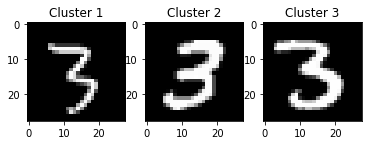

In [ ]:
x_0_c1, y_0_c1, x_0_c2, y_0_c2, x_0_c3, y_0_c3 = create_kmeans_clusters(data[0][0], data[0][1])
fig, axs = plt.subplots(1, 3)
axs[0].imshow(x_0_c1[0].reshape(28,28),cmap='gray')
axs[0].set_title('Cluster 1')
axs[1].imshow(x_0_c2[0].reshape(28,28),cmap='gray')
axs[1].set_title('Cluster 2')
axs[2].imshow(x_0_c3[0].reshape(28,28),cmap='gray')
axs[2].set_title('Cluster 3')

Text(0.5, 1.0, 'Cluster 3')

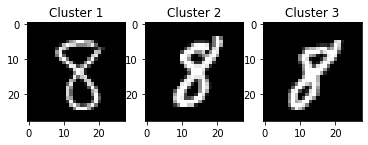

In [ ]:
x_6_c1, y_6_c1, x_6_c2, y_6_c2, x_6_c3, y_6_c3 = create_kmeans_clusters(data[1][0], data[1][1])
fig, axs = plt.subplots(1, 3)
axs[0].imshow(x_6_c1[0].reshape(28,28),cmap='gray')
axs[0].set_title('Cluster 1')
axs[1].imshow(x_6_c2[0].reshape(28,28),cmap='gray')
axs[1].set_title('Cluster 2')
axs[2].imshow(x_6_c3[0].reshape(28,28),cmap='gray')
axs[2].set_title('Cluster 3')

### Creation of individual train sets for the clients, global train set for the SVM model and a global test set containing the data from all the clusters



In [ ]:
clients_X,clients_y,X_test,y_test = get_clients(data[0][0], data[1][0], n_clients = 3)

In [ ]:
xtrain_gl, ytrain_gl = get_total_from_clients(clients_X,clients_y)

### Federated learning model and SVM model training

#### Training the models without validation

In [ ]:
f_svm = Federated_SVM(n_clients = 3, val=False)
f_svm.create_clients(clients_X,clients_y,X_test,y_test)
clients = copy.deepcopy(f_svm.clients)

In [ ]:
clf = SVM(xtrain_gl, ytrain_gl, X_test, y_test, val=False)
clf.fit()
print(clf.accuracy())

96.63685152057245


In [ ]:
f_svm.fit(10,f_svm.average_aggregator)

global round 1
client 1 79.06976744186046
client 2 81.96779964221824
client 3 72.77280858676207
global test acc 95.67084078711986
global round 2
client 1 80.46511627906978
client 2 82.03935599284436
client 3 72.84436493738819
global test acc 95.81395348837209
global round 3
client 1 79.71377459749553
client 2 81.18067978533094
client 3 72.88014311270126
global test acc 95.8855098389982
global round 4
client 1 79.42754919499106
client 2 82.36135957066189
client 3 71.73524150268337
global test acc 95.95706618962433
global round 5
client 1 79.5706618962433
client 2 82.64758497316636
client 3 72.41502683363149
global test acc 95.9928443649374
global round 6
client 1 79.64221824686942
client 2 82.43291592128801
client 3 72.62969588550983
global test acc 95.9928443649374
global round 7
client 1 80.03577817531306
client 2 81.89624329159213
client 3 72.9159212880143
global test acc 95.9928443649374
global round 8
client 1 78.96243291592128
client 2 81.35957066189624
client 3 72.3076923076923
g

#### Training the models with cross validation (balanced validation distribution)

In [ ]:
f_svm = Federated_SVM(n_clients = 3, val=True, val_type='cross_val', val_distribution='balanced')
f_svm.create_clients(clients_X,clients_y,X_test,y_test)
clients = copy.deepcopy(f_svm.clients)

In [ ]:
clf = SVM(xtrain_gl, ytrain_gl, X_test, y_test, val=True, val_type='cross_val', val_distribution='balanced')
clf.fit()
print(clf.accuracy())

96.67262969588552


In [ ]:
f_svm.fit(10,f_svm.average_aggregator)

global round 1
client 1 81.35957066189624
client 2 84.25760286225402
client 3 72.62969588550983
global test acc 95.77817531305904
global round 2
client 1 82.03935599284436
client 2 85.08050089445437
client 3 75.02683363148479
global test acc 96.02862254025045
global round 3
client 1 83.29159212880143
client 2 85.29516994633273
client 3 87.11985688729875
global test acc 96.02862254025045
global round 4
client 1 82.7906976744186
client 2 89.83899821109124
client 3 75.52772808586762
global test acc 96.27906976744185
global round 5
client 1 87.40608228980322
client 2 91.01967799642217
client 3 88.15742397137745
global test acc 96.63685152057245
global round 6
client 1 82.14669051878354
client 2 83.50626118067979
client 3 77.53130590339893
global test acc 96.63685152057245
global round 7
client 1 84.22182468694098
client 2 84.18604651162791
client 3 75.24150268336315
global test acc 96.63685152057245
global round 8
client 1 83.25581395348837
client 2 85.97495527728086
client 3 75.7781753130

#### Training the models with cross validation (unbalanced validation distribution)

In [ ]:
f_svm = Federated_SVM(n_clients = 3, val=True, val_type='cross_val', val_distribution='unbalanced')
f_svm.create_clients(clients_X,clients_y,X_test,y_test)
clients = copy.deepcopy(f_svm.clients)

In [ ]:
clf = SVM(xtrain_gl, ytrain_gl, X_test, y_test, val=True, val_type='cross_val', val_distribution='unbalanced')
clf.fit()
print(clf.accuracy())

96.2432915921288


In [ ]:
f_svm.fit(10,f_svm.average_aggregator)

global round 1
client 1 81.1449016100179
client 2 82.82647584973166
client 3 75.20572450805008
global test acc 95.2772808586762
global round 2
client 1 82.64758497316636
client 2 83.25581395348837
client 3 74.4186046511628
global test acc 95.2772808586762
global round 3
client 1 84.40071556350625
client 2 90.6618962432916
client 3 75.02683363148479
global test acc 95.95706618962433
global round 4
client 1 88.15742397137745
client 2 91.37745974955277
client 3 75.31305903398928
global test acc 95.95706618962433
global round 5
client 1 88.72987477638641
client 2 86.76207513416816
client 3 87.19141323792486
global test acc 96.42218246869409
global round 6
client 1 89.40966010733452
client 2 85.08050089445437
client 3 76.6010733452594
global test acc 96.42218246869409
global round 7
client 1 83.04114490161002
client 2 90.37567084078711
client 3 75.16994633273703
global test acc 96.42218246869409
global round 8
client 1 81.7531305903399
client 2 87.47763864042933
client 3 76.17173524150267
g

#### Training the models with 5 fold cross validation (balanced validation distribution)

In [ ]:
f_svm = Federated_SVM(n_clients = 3, val=True, val_type='k_fold', val_distribution='balanced', k=5)
f_svm.create_clients(clients_X,clients_y,X_test,y_test)
clients = copy.deepcopy(f_svm.clients)

In [ ]:
clf = SVM(xtrain_gl, ytrain_gl, X_test, y_test, val=True, val_type='k_fold', val_distribution='balanced', k=5)
clf.fit()
print(clf.accuracy())

96.20751341681574
96.77996422182468
96.70840787119856
96.92307692307692
96.6010733452594
96.92307692307692


In [ ]:
f_svm.fit(5,f_svm.average_aggregator)

global round 1
82.93381037567083
81.9320214669052
83.47048300536673
82.11091234347049
82.11091234347049
client 1 81.9320214669052
82.39713774597496
83.47048300536673
83.86404293381038
84.25760286225402
81.71735241502684
client 2 84.25760286225402
75.31305903398928
74.91949910554561
74.77638640429338
74.91949910554561
74.77638640429338
client 3 75.31305903398928
global test acc 95.74239713774597
global round 2
83.86404293381038
88.22898032200358
83.00536672629696
82.75491949910555
83.07692307692308
client 1 88.22898032200358
89.08765652951699
90.19677996422183
85.5098389982111
85.47406082289804
84.40071556350625
client 2 85.47406082289804
75.13416815742397
87.15563506261181
87.29874776386404
75.2772808586762
75.34883720930232
client 3 75.13416815742397
global test acc 95.81395348837209
global round 3
84.22182468694098
82.9695885509839
82.86225402504472
88.62254025044723
81.46690518783542
client 1 82.9695885509839
89.83899821109124
84.25760286225402
89.08765652951699
85.54561717352415
89

#### Training the models with 5 fold cross validation (unbalanced validation distribution)

In [ ]:
f_svm = Federated_SVM(n_clients = 3, val=True, val_type='k_fold', val_distribution='unbalanced', k=5)
f_svm.create_clients(clients_X,clients_y,X_test,y_test)
clients = copy.deepcopy(f_svm.clients)

In [ ]:
clf = SVM(xtrain_gl, ytrain_gl, X_test, y_test, val=True, val_type='k_fold', val_distribution='unbalanced', k=5)
clf.fit()
print(clf.accuracy())

96.81574239713775
96.74418604651163
96.88729874776386
96.67262969588552
96.77996422182468
96.74418604651163


In [ ]:
f_svm.fit(5,f_svm.average_aggregator)

global round 1
83.50626118067979
83.14847942754919
81.89624329159213
82.25402504472272
80.57245080500894
client 1 80.57245080500894
84.07871198568873
80.35778175313058
82.57602862254025
83.43470483005366
81.96779964221824
client 2 84.07871198568873
74.88372093023256
75.45617173524151
74.88372093023256
75.95706618962433
72.84436493738819
client 3 74.88372093023256
global test acc 95.70661896243293
global round 2
82.28980322003578
83.11270125223614
81.96779964221824
82.86225402504472
84.36493738819321
client 1 82.86225402504472
89.58855098389982
85.54561717352415
85.08050089445437
84.32915921288014
82.9695885509839
client 2 85.08050089445437
75.6350626118068
75.31305903398928
73.13059033989266
74.09660107334525
86.86940966010734
client 3 75.6350626118068
global test acc 95.77817531305904
global round 3
88.72987477638641
84.18604651162791
83.3273703041145
83.29159212880143
88.58676207513417
client 1 84.18604651162791
90.12522361359571
85.25939177101968
85.43828264758497
89.91055456171735
